In [4]:
# import des constantes necessaires
from scipy.constants import Avogadro, c, m_e, m_p,e
# m_e = m_e/(c**2)
# m_p = m_p/(c**2)
import numpy as np # get down babyyyyy
import matplotlib.pyplot as plt # beaux graphiques stylé
m_p = m_p  * 1e-6/e
m_e = m_e  * 1e-6/e
m_e

5.6856301035657226e-18

# Q1
Exprimez la densité électronique $n_e$ d’un milieu en fonction de sa composition atomique et de sa masse volumique $\rho$, et calculer $n_e$ pour l’eau (liquide) et l’os compact (définition de l’ICRU). On s’appuiera sur les données du NIST pour les compositions atomiques de ces matériaux.

In [144]:
# fonction pour le calcul de n_e, source : chatgpt
n_e = lambda atomic_numbers, fractions_by_weight, rho, A: rho * Avogadro * np.sum(atomic_numbers * fractions_by_weight/A)

rho_bone = 1.85 #g/cm^3
atomic_numbers_bone = np.array([1, 6, 7, 8, 12, 15, 16, 20])
fractions_by_weight_bone = np.array([0.063984, 0.278000, 0.027000, 0.410016, 0.002000, 0.070000, 0.002000, 0.147000])
A_bone = np.array([1.008, 12.011, 14.007, 15.999, 24.305, 30.974, 32.065, 40.078])
I_bone = 91.9 * 1e-6 # MeV

n_e_bone = n_e(atomic_numbers_bone, fractions_by_weight_bone, rho_bone, A_bone)

rho_water = 1
I_water = 75 * 1e-6 # MeV
A_water = np.array([1.008, 15.999])
atomic_numbers_water = np.array([1, 8])
fractions_by_weight_water = np.array([0.111894, 0.888106])

n_e_water = n_e(atomic_numbers_water, fractions_by_weight_water, rho_water, A_water)

# Q2

In [145]:
def stopping_power_col(beta, gamma, n_e, I_MeV, T_max):

    # Constants
    r_e = 2.81794e-13  # Classical electron radius (cm)


    # Compute the stopping power
    S_col = (2 * np.pi * r_e**2 * m_e * c**2 * n_e) / (beta**2+np.finfo(np.float64).eps) * (
        np.log(np.finfo(np.float64).eps + (2 * m_e * c**2 * beta**2 * gamma**2 * T_max) / I_MeV**2) - 2 * beta**2)

    return S_col


In [162]:
def T_max_e(gamma):
    """
    Calculate T_max^e, the maximum energy transferable to an electron by a proton.

    Parameters:
        gamma (float): Lorentz factor (1 / sqrt(1 - beta^2)).

    Returns:
        float: Maximum transferable energy T_max^e (MeV).
    """


    # Calculate coefficients
    a = 2 * m_e * c**2
    b = 1 + (m_e / m_p)**2
    delta = 2 * (m_e / m_p)

    # Calculate T_max^e
    T_max = (a * (gamma**2 - 1)) / (b + delta * gamma)
    return T_max

beta = np.linspace(0,1,1000)
beta
gamma = 1 / np.sqrt(1 - beta**2 + np.finfo(np.float64).eps)
T_max = T_max_e(gamma)
T = (gamma - 1)*m_p * c**2

S_col_water = stopping_power_col(beta, gamma, n_e_water, I_water, T_max)
S_col_bone = stopping_power_col(beta, gamma, n_e_bone, I_bone, T_max)

print(f"Stopping Power S_col_bone: {S_col_bone} MeV/cm")
print(f"Stopping Power S_col_water: {S_col_water} MeV/cm")

Stopping Power S_col_bone: [-2.44419726e+16 -1.35169397e+06 -2.33762739e+05 -7.68144908e+04
 -3.24004965e+04 -1.53711541e+04 -7.63020573e+03 -3.71488079e+03
 -1.59007709e+03 -3.82307044e+02  3.23641552e+02  7.40942451e+02
  9.85802781e+02  1.12466494e+03  1.19700943e+03  1.22704307e+03
  1.22999247e+03  1.21563617e+03  1.19035845e+03  1.15838044e+03
  1.12251791e+03  1.08465848e+03  1.04606829e+03  1.00759265e+03
  9.69789279e+02  9.33018038e+02  8.97502088e+02  8.63369968e+02
  8.30684820e+02  7.99464813e+02  7.69697513e+02  7.41350020e+02
  7.14376143e+02  6.88721474e+02  6.64326976e+02  6.41131500e+02
  6.19073540e+02  5.98092438e+02  5.78129196e+02  5.59126996e+02
  5.41031527e+02  5.23791154e+02  5.07356992e+02  4.91682906e+02
  4.76725453e+02  4.62443805e+02  4.48799636e+02  4.35757004e+02
  4.23282226e+02  4.11343745e+02  3.99912007e+02  3.88959333e+02
  3.78459798e+02  3.68389117e+02  3.58724535e+02  3.49444726e+02
  3.40529691e+02  3.31960674e+02  3.23720071e+02  3.15791354e+0

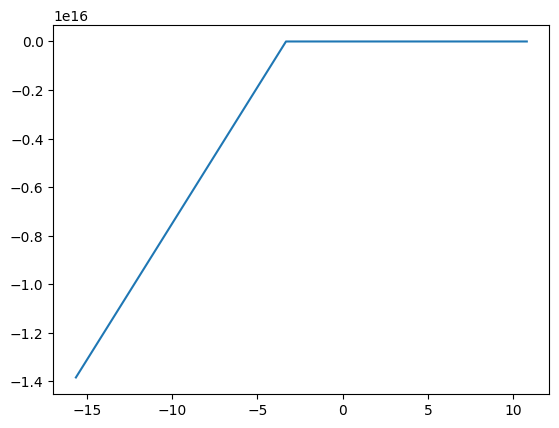

In [183]:
plt.plot(np.log10(T + np.finfo(np.float64).eps), S_col_water)

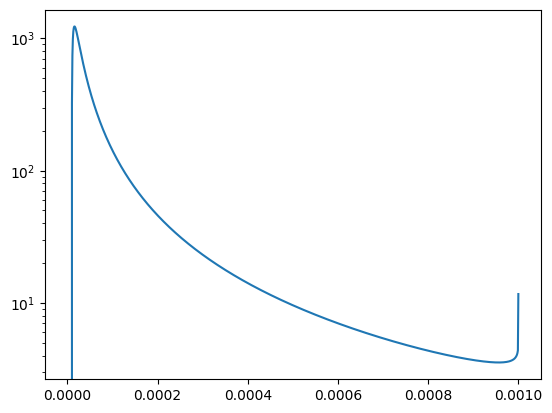

In [159]:
plt.semilogy(beta/1000,S_col_bone)

In [110]:
n_e_water

3.342810286137214e+23

In [111]:
n_e_bone

5.905875865014682e+23

In [112]:
m_p

1.67262192369e-27

In [113]:
m_e

9.1093837015e-31

# Q3


Les données PSTAR sont données ici : https://physics.nist.gov/PhysRefData/Star/Text/PSTAR.html.


Pour l'eau liquide:

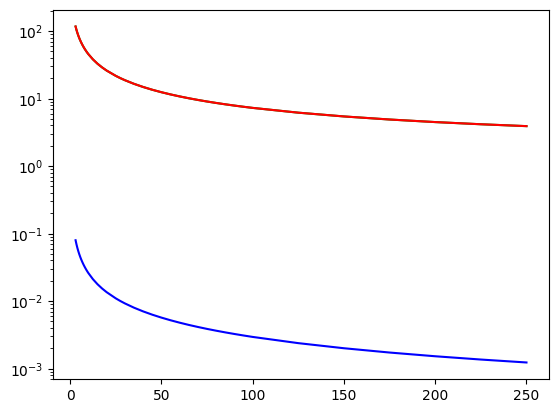

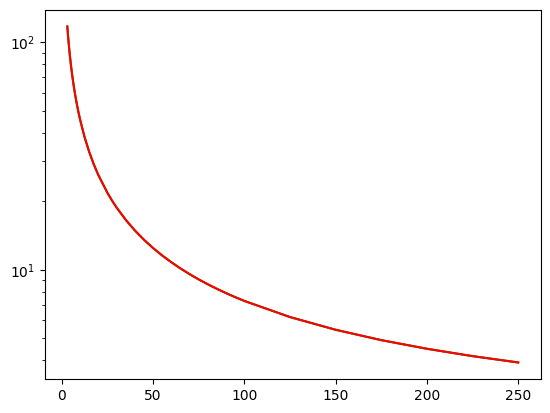

In [11]:
# Données sous forme de chaîne brute
data_eau_liquide = """
3.000E+00 1.171E+02 7.972E-02 1.172E+02
3.500E+00 1.041E+02 6.916E-02 1.042E+02
4.000E+00 9.398E+01 6.113E-02 9.404E+01
4.500E+00 8.580E+01 5.481E-02 8.586E+01
5.000E+00 7.906E+01 4.970E-02 7.911E+01
5.500E+00 7.339E+01 4.549E-02 7.343E+01
6.000E+00 6.854E+01 4.195E-02 6.858E+01
6.500E+00 6.434E+01 3.894E-02 6.438E+01
7.000E+00 6.068E+01 3.634E-02 6.071E+01
7.500E+00 5.744E+01 3.407E-02 5.747E+01
8.000E+00 5.456E+01 3.208E-02 5.460E+01
8.500E+00 5.199E+01 3.031E-02 5.202E+01
9.000E+00 4.966E+01 2.873E-02 4.969E+01
9.500E+00 4.756E+01 2.731E-02 4.759E+01
1.000E+01 4.564E+01 2.603E-02 4.567E+01
1.250E+01 3.813E+01 2.111E-02 3.815E+01
1.500E+01 3.290E+01 1.778E-02 3.292E+01
1.750E+01 2.904E+01 1.538E-02 2.905E+01
2.000E+01 2.605E+01 1.356E-02 2.607E+01
2.500E+01 2.174E+01 1.098E-02 2.175E+01
2.750E+01 2.012E+01 1.003E-02 2.013E+01
3.000E+01 1.875E+01 9.239E-03 1.876E+01
3.500E+01 1.656E+01 7.983E-03 1.656E+01
4.000E+01 1.487E+01 7.034E-03 1.488E+01
4.500E+01 1.353E+01 6.290E-03 1.354E+01
5.000E+01 1.244E+01 5.691E-03 1.245E+01
5.500E+01 1.154E+01 5.199E-03 1.154E+01
6.000E+01 1.078E+01 4.786E-03 1.078E+01
6.500E+01 1.012E+01 4.435E-03 1.013E+01
7.000E+01 9.555E+00 4.134E-03 9.559E+00
7.500E+01 9.059E+00 3.871E-03 9.063E+00
8.000E+01 8.622E+00 3.641E-03 8.625E+00
8.500E+01 8.233E+00 3.437E-03 8.236E+00
9.000E+01 7.884E+00 3.255E-03 7.888E+00
9.500E+01 7.570E+00 3.092E-03 7.573E+00
1.000E+02 7.286E+00 2.944E-03 7.289E+00
1.250E+02 6.190E+00 2.381E-03 6.192E+00
1.500E+02 5.443E+00 2.001E-03 5.445E+00
1.750E+02 4.901E+00 1.728E-03 4.903E+00
2.000E+02 4.491E+00 1.522E-03 4.492E+00
2.250E+02 4.169E+00 1.361E-03 4.170E+00
2.500E+02 3.910E+00 1.231E-03 3.911E+00
"""

#Convertir en listes.

lignes = data_eau_liquide.strip().split("\n")

Ke_Mev_eau_liquide = []
Stopping_power_Nuclear_eau_liquide = []
Stopping_power_Electronic_eau_liquide = []
Stopping_power_total_eau_liquide = []

for ligne in lignes:
    col1, col2, col3, col4 = map(float, ligne.split())
    Ke_Mev_eau_liquide.append(col1)
    Stopping_power_Electronic_eau_liquide.append(col2)
    Stopping_power_Nuclear_eau_liquide.append(col3)
    Stopping_power_total_eau_liquide.append(col4)

plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Electronic_eau_liquide, 'g')
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Nuclear_eau_liquide, 'b')
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_total_eau_liquide, 'r')

plt.show()

plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Electronic_eau_liquide, 'g')
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_total_eau_liquide, 'r')

plt.show()


Nous pouvons voir qu'il n'est pas nécessaire de considérer l'effet atomique. En effet, sa contribution est très minime. Le premier graph montre les contribution de toutes les parties alors que le deuxième graph montre le stopping power total et électronique.

Pour l'os compact:

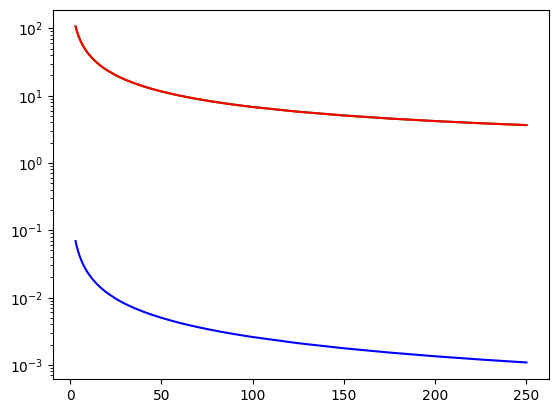

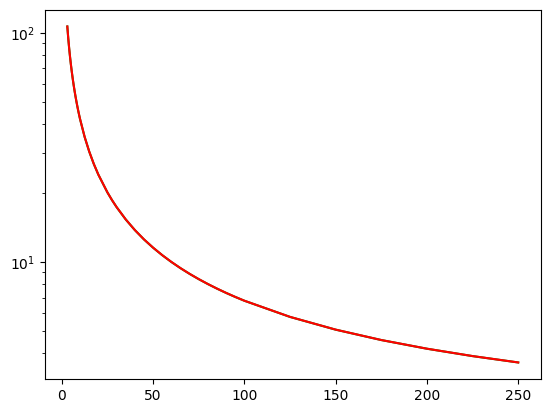

In [16]:
data_os_compact = """
3.000E+00 1.065E+02 6.903E-02 1.065E+02
3.500E+00 9.484E+01 5.994E-02 9.490E+01
4.000E+00 8.571E+01 5.303E-02 8.576E+01
4.500E+00 7.834E+01 4.759E-02 7.838E+01
5.000E+00 7.224E+01 4.318E-02 7.228E+01
5.500E+00 6.711E+01 3.955E-02 6.715E+01
6.000E+00 6.272E+01 3.649E-02 6.276E+01
6.500E+00 5.892E+01 3.388E-02 5.896E+01
7.000E+00 5.560E+01 3.163E-02 5.563E+01
7.500E+00 5.266E+01 2.967E-02 5.269E+01
8.000E+00 5.005E+01 2.795E-02 5.008E+01
8.500E+00 4.771E+01 2.641E-02 4.774E+01
9.000E+00 4.560E+01 2.505E-02 4.562E+01
9.500E+00 4.368E+01 2.382E-02 4.371E+01
1.000E+01 4.194E+01 2.271E-02 4.196E+01
1.250E+01 3.509E+01 1.844E-02 3.511E+01
1.500E+01 3.032E+01 1.554E-02 3.033E+01
1.750E+01 2.678E+01 1.345E-02 2.679E+01
2.000E+01 2.405E+01 1.187E-02 2.406E+01
2.500E+01 2.009E+01 9.619E-03 2.010E+01
2.750E+01 1.861E+01 8.793E-03 1.861E+01
3.000E+01 1.735E+01 8.100E-03 1.736E+01
3.500E+01 1.533E+01 7.003E-03 1.534E+01
4.000E+01 1.378E+01 6.173E-03 1.378E+01
4.500E+01 1.254E+01 5.522E-03 1.255E+01
5.000E+01 1.154E+01 4.998E-03 1.155E+01
5.500E+01 1.071E+01 4.567E-03 1.071E+01
6.000E+01 1.000E+01 4.205E-03 1.001E+01
6.500E+01 9.398E+00 3.898E-03 9.401E+00
7.000E+01 8.874E+00 3.633E-03 8.878E+00
7.500E+01 8.416E+00 3.403E-03 8.420E+00
8.000E+01 8.012E+00 3.201E-03 8.015E+00
8.500E+01 7.652E+00 3.022E-03 7.655E+00
9.000E+01 7.329E+00 2.862E-03 7.332E+00
9.500E+01 7.039E+00 2.719E-03 7.042E+00
1.000E+02 6.776E+00 2.590E-03 6.778E+00
1.250E+02 5.760E+00 2.095E-03 5.762E+00
1.500E+02 5.068E+00 1.762E-03 5.070E+00
1.750E+02 4.566E+00 1.522E-03 4.567E+00
2.000E+02 4.185E+00 1.340E-03 4.186E+00
2.250E+02 3.886E+00 1.198E-03 3.887E+00
2.500E+02 3.645E+00 1.084E-03 3.646E+00
"""

lignes = data_os_compact.strip().split("\n")

Ke_Mev_os_compact = []
Stopping_power_Nuclear_os_compact = []
Stopping_power_Electronic_os_compact = []
Stopping_power_total_os_compact = []

for ligne in lignes:
    col1, col2, col3, col4 = map(float, ligne.split())
    Ke_Mev_os_compact.append(col1)
    Stopping_power_Electronic_os_compact.append(col2)
    Stopping_power_Nuclear_os_compact.append(col3)
    Stopping_power_total_os_compact.append(col4)

plt.semilogy(Ke_Mev_os_compact, Stopping_power_Electronic_os_compact, 'g')
plt.semilogy(Ke_Mev_os_compact, Stopping_power_Nuclear_os_compact, 'b')
plt.semilogy(Ke_Mev_os_compact, Stopping_power_total_os_compact, 'r')

plt.show()

plt.semilogy(Ke_Mev_os_compact, Stopping_power_Electronic_os_compact, 'g')
plt.semilogy(Ke_Mev_os_compact, Stopping_power_total_os_compact, 'r')

plt.show()